In [7]:
import kaleido
import pandas as pd
import numpy as np
import plotly.graph_objects as go
######## Search space #########
import sys
sys.path.append("../")
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results
# Initialize an empty list to store dictionaries
def results_to_df(path, name):
    data = []
    # Open the text file
    with open(path, 'r') as file:
        lines = file.readlines()
        # Initialize an empty dictionary to store data for each block
        block_data = {}
        for line in lines:
            # If the line contains dashes, it indicates the end of a block
            if '-------------------------' in line:
                # If block_data is not empty, add it to the list of data dictionaries
                if block_data:
                    data.append(block_data)
                    # Reset block_data for the next block
                    block_data = {}
            elif 'best_acc' in line:
                continue
            else:
                # Split the line by ':'
                #print(line)
                key, value = line.strip().split(': ')
                # Store the key-value pair in the block_data dictionary
                block_data[key] = value

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types if needed
    df['epoch'] = df['epoch'].astype(int)
    df['lr'] = df['lr'].astype(float)
    df['train_acc'] = df['train_acc'].astype(float)
    df['train_loss'] = df['train_loss'].astype(float)
    df['test_acc'] = df['test_acc'].astype(float)
    df['test_acc_top5'] = df['test_acc_top5'].astype(float)
    df['test_loss'] = df['test_loss'].astype(float)
    df['epoch_time'] = df['epoch_time'].astype(float)
    df=df.assign(name=name)
    
    return df

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import json
import os

metadata_dict={}
metadata_dict["Caitie"]={'num_classes': 4,
                         'input_shape': [49260, 3, 64, 64],
                         'codename': 'Caitie',
                         'benchmark': 47.008,
                         }
metadata_dict["Adaline"]={'num_classes': 20,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Adaline',
                         'benchmark': 89.85}
metadata_dict["Chester"]={'input_shape': [49998, 12, 8, 8],
                         'codename': 'Chester',
                         'benchmark': 57.826,
                         'num_classes': 3}
metadata_dict["Gutenberg"]={'input_shape': [45000, 1, 27, 18],
                         'codename': 'Gutenberg',
                         'benchmark': 40.98,
                         'num_classes': 6}
metadata_dict["LaMelo"]={'num_classes': 10,
                         'codename': 'LaMelo',
                         'input_shape': [50000, 1, 24, 24],
                         'benchmark': 85.2}
metadata_dict["Mateo"]={'num_classes': 10,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Mateo',
                         'benchmark': 90.87}
metadata_dict["Sadie"]={'input_shape': [50000, 3, 64, 64],
                         'codename': 'Sadie',
                         'benchmark': 80.33,
                         'num_classes': 10}
metadata_dict["Sokoto"]={'input_shape': [50000, 1, 9, 9],
                         'codename': 'Sokoto',
                         'benchmark': 0.0,
                         'num_classes': 9}
def get_predictor_data_from_folder(base_folder,studies):

    
    train_data=[]
    for study_name in studies: 
        

        metadata=metadata_dict[study_name]
        rg=RegNet(metadata,
                        W0=[16, 120, 8],
                        WA=[16, 64, 8],
                        WM=[2.05,2.9,0.05],
                        D=[8,22,1], 
                        G=[8,8,8], 
                        base_config=f"../configs/search_space/config.yaml")
        data=[]
        study_folder=f"{base_folder}/{study_name}"
        subjects= os.listdir(study_folder)

        subjects=[subject for subject in subjects if os.path.isdir(f"{study_folder}/{subject}")]
        print(subjects)
        for name in subjects:
            try:
                test_acc=results_to_df(f"{study_folder}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_acc":"acc","test_loss":"test_acc"})
                #print(test_acc.columns)
                if len(test_acc)>49:
                    test_acc_piv = test_acc[["epoch","test_acc","name"]].pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                    test_acc_piv["best_acc"]=test_acc["test_acc"].max()
                    
                    model, info=rg.load_model(config_file=f"{study_folder}/{name}/config.yaml")
                    test_acc_piv["gen"]=1
                    test_acc_piv["num_stages"]=info["num_stages"]
                    test_acc_piv["params"]=info["params"]
                    test_acc_piv["WA"]=info["WA"]
                    test_acc_piv["W0"]=info["W0"]
                    test_acc_piv["WM"]=info["WM"]
                    test_acc_piv["DEPTH"]=info["DEPTH"]
                    test_acc_piv["num_classes"]=metadata["num_classes"]
                    test_acc_piv["num_channels"]=metadata["input_shape"][1]
                    test_acc_piv["benchmark"]=metadata["benchmark"]
                    test_acc_piv["codename"]=study_name
                    
                    #print(info)
                    data.append(test_acc_piv)
            except:
                    pass

        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data
    

In [9]:
import json


def get_predictor_data(tests_folder,studies):
    train_data=[]
    for study_name in studies: 
        #study_name="tests_LaMelo_13_06_2024_02_11"
        file_path=f"{tests_folder}/{study_name}/{study_name}.evonas"
        with open(file_path, 'r') as file:
            results = json.load(file)

        individuals_df=pd.read_json(results["results"]).sort_values("name")[["name","generation"]]
        data_models=pd.read_json(results["results"])[["name","num_stages","params","WA","W0","WM","DEPTH", "best_acc"]]
        data_models["num_classes"]=results["metadata"]["num_classes"]
        data_models["num_channels"]=results["metadata"]["input_shape"][1]
        data_models["benchmark"]=results["metadata"]["benchmark"]
       
        print(study_name)
        print(results["metadata"])

        data=[]
        for index, row in individuals_df.iterrows():
            name=row["name"]
            generation=row["generation"]
            try:
                test_acc=results_to_df(f"{tests_folder}/{study_name}/Generation_{generation}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_loss":"test_acc"})
                test_acc_piv = test_acc.pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                test_acc_piv["gen"]=generation
                data.append(pd.merge(test_acc_piv, data_models, on="name"))
            except:
                pass
        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data

In [10]:
test_dataset="Sokoto"
add_zcost_features=False
corr_scores={}
accuracies={}
test_accuracies={}
epochs_results={}

In [11]:
studies=["LaMelo","Caitie", "Adaline","Gutenberg","Sadie", "Chester", "Mateo"]
train_studies=[dataset for dataset in studies if dataset!=test_dataset]
test_studies=[test_dataset]

In [12]:
train_studies

['LaMelo', 'Caitie', 'Adaline', 'Gutenberg', 'Sadie', 'Chester', 'Mateo']

In [13]:
train_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
                                          studies=train_studies)
#test_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
#                                         studies=test_studies)

['dangerous_degu', 'didactic_armadillo', 'tiny_sturgeon', 'jolly_buzzard', 'great_prawn', 'illustrious_trout', 'notorious_sawfly', 'merry_lizard', 'outstanding_mantis', 'fluffy_boa', 'logical_hornet', 'great_coyote', 'discerning_beluga', 'monumental_galago', 'colossal_hedgehog', 'fragrant_skylark', 'vivid_owl', 'wandering_silkworm', 'jasmine_dugong', 'ultramarine_caiman', 'astute_barracuda', 'silver_ammonite', 'foamy_rat', 'camouflaged_kittiwake', 'quick_prawn', 'angelic_coati', 'tested_nuthatch', 'prompt_dog', 'organic_lorikeet', 'convivial_jellyfish', 'enlightened_impala', 'scarlet_grasshopper', 'jade_baboon', 'adaptable_jacamar', 'real_caterpillar', 'poised_frog', 'cornflower_salamander', 'curious_viper', 'elated_pig', 'gleaming_hawk', 'fluorescent_antelope', 'antique_anteater', 'inventive_jellyfish', 'curly_emu', 'auburn_sturgeon', 'fat_parakeet', 'unique_grasshopper', 'demonic_hornet', 'crafty_hyrax', 'orange_ara', 'thundering_seahorse', 'lime_hyena', 'vanilla_ara', 'peculiar_dorm

In [14]:
test_data=pd.DataFrame()

In [15]:
if add_zcost_features:
    dfs_zcost=[]
    for codename in studies:
        df_zcost=pd.read_csv(f"zcost_proxies/results/{codename}_clf_train.csv", index_col=0)
        df_zcost["codename"]=codename
        dfs_zcost.append(df_zcost)

    dfs_zcost=pd.concat(dfs_zcost)
    train_data=pd.merge(train_data, dfs_zcost, on=["name","codename"])
    test_data=pd.merge(test_data, dfs_zcost, on=["name","codename"])

In [16]:
train_data

epoch,name,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark,codename
0,dangerous_degu,62.78,73.48,79.53,79.54,80.40,80.76,83.01,80.76,82.04,...,3,3067032,24.0,96,2.70,15,10,1,85.20,LaMelo
0,didactic_armadillo,64.19,72.69,75.78,75.92,78.89,79.14,80.58,80.85,81.59,...,3,1075888,40.0,40,2.50,9,10,1,85.20,LaMelo
0,tiny_sturgeon,46.45,62.11,68.76,72.06,75.72,78.56,77.90,78.40,79.64,...,4,22485560,56.0,80,2.20,20,10,1,85.20,LaMelo
0,jolly_buzzard,63.87,74.59,77.44,78.44,78.98,80.46,82.19,81.64,81.27,...,3,5602612,48.0,120,2.25,11,10,1,85.20,LaMelo
0,great_prawn,46.35,60.89,67.49,74.89,75.20,77.14,77.74,79.70,79.50,...,4,24112968,56.0,80,2.25,20,10,1,85.20,LaMelo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ancient_swine,24.57,29.90,35.15,33.21,37.74,54.02,72.44,79.79,83.12,...,3,5755213,16.0,104,2.45,22,10,3,90.87,Mateo
0,persimmon_starling,22.55,28.03,31.25,35.10,36.05,39.65,52.40,67.32,68.08,...,4,28925507,64.0,88,2.25,20,10,3,90.87,Mateo
0,loose_poodle,26.26,27.91,33.58,36.48,55.12,68.31,65.57,81.60,77.48,...,3,6913753,40.0,80,2.50,16,10,3,90.87,Mateo
0,whispering_hamster,19.79,23.93,27.34,31.78,34.33,36.04,46.61,59.07,60.75,...,4,14433859,40.0,48,2.45,21,10,3,90.87,Mateo


In [17]:
#test_data=pd.DataFrame()

In [18]:
train_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                          studies=train_studies)
test_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                         studies=test_studies)

['porcelain_anteater', 'lilac_dingo', 'unique_cockatoo', 'aloof_crow', 'mysterious_wombat', 'furry_binturong', 'loyal_sheep', 'muscular_stork', 'outgoing_goose', 'colorful_vulture', 'sceptical_foxhound', 'alluring_gibbon', 'banana_bee', 'crafty_jellyfish', 'truthful_cuscus', 'asparagus_kangaroo', 'chocolate_silkworm', 'enlightened_cuscus', 'cooperative_teal', 'devout_panda', 'hallowed_pug', 'elated_lionfish', 'nano_dinosaur', 'perky_bulldog', 'wondrous_crayfish', 'precise_rottweiler', 'funky_sponge', 'phenomenal_sidewinder', 'amiable_cow', 'powerful_locust', 'delectable_fennec', 'gray_tarsier', 'romantic_adder', 'heretic_nyala', 'observant_ringtail', 'ultramarine_iguana', 'mutant_sambar', 'ultraviolet_rattlesnake', 'devout_dingo', 'ancient_poodle', 'curvy_jaguarundi', 'rainbow_manatee', 'ochre_cat', 'tangerine_crayfish', 'arboreal_kudu', 'attentive_agouti', 'zippy_mastodon', 'literate_magpie', 'meticulous_gerbil', 'fresh_ibis', 'rose_smilodon', 'imaginary_tiger', 'magnificent_impala', 

In [19]:
if add_zcost_features:
    dfs_zcost=[]
    for codename in studies:
        df_zcost=pd.read_csv(f"zcost_proxies/results/{codename}.csv", index_col=0)
        df_zcost["codename"]=codename
        dfs_zcost.append(df_zcost)

    dfs_zcost=pd.concat(dfs_zcost)
    train_data_2=pd.merge(train_data_2, dfs_zcost, on=["name","codename"])
    test_data_2=pd.merge(test_data_2, dfs_zcost, on=["name","codename"])

In [20]:
test_data_2

epoch,name,epoch_0,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,...,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark,codename
0,phenomenal_mamba,11.11,11.33,12.75,14.62,16.71,19.73,21.26,24.47,24.81,...,3,10283244,32.0,120,2.20,19,9,1,0.0,Sokoto
0,hasty_dodo,11.10,11.17,11.47,12.09,15.03,17.15,18.11,20.15,21.39,...,3,3137570,24.0,48,2.55,18,9,1,0.0,Sokoto
0,dancing_goose,11.11,12.85,14.92,16.25,18.60,20.19,21.24,22.79,27.13,...,3,11542470,24.0,120,2.50,21,9,1,0.0,Sokoto
0,radical_hyena,11.58,12.15,12.46,12.40,12.00,14.11,14.59,16.00,16.81,...,4,20279922,56.0,104,2.25,17,9,1,0.0,Sokoto
0,faithful_cassowary,11.11,15.00,18.23,22.78,24.82,28.73,31.22,34.11,34.23,...,2,1638362,24.0,112,2.35,11,9,1,0.0,Sokoto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,daffodil_seal,11.11,11.63,12.01,11.88,12.65,13.71,15.49,17.34,17.24,...,4,6621934,48.0,64,2.10,14,9,1,0.0,Sokoto
0,flawless_jacamar,11.11,11.31,11.13,12.14,12.24,14.26,15.93,16.99,18.05,...,4,7606698,48.0,56,2.20,15,9,1,0.0,Sokoto
0,able_hare,11.13,12.68,15.44,17.02,19.31,24.26,27.10,27.74,30.02,...,3,5012566,48.0,112,2.10,12,9,1,0.0,Sokoto
0,poetic_gecko,11.11,11.12,11.60,10.97,12.16,12.59,16.30,18.31,21.82,...,3,19939916,64.0,112,2.70,18,9,1,0.0,Sokoto


In [21]:
train_data= pd.concat([train_data,train_data_2]).drop(columns=["epoch_0", "codename"])

In [22]:
train_data[train_data.duplicated(subset=['name', 'benchmark'], keep=False)]

epoch,name,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,gen,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark
0,delectable_crab,12.28,17.03,23.49,27.44,29.73,37.18,44.79,47.17,54.16,...,1,4,14974367,40.0,48,2.55,20,20,3,89.85
0,delectable_crab,20.85,33.90,45.53,41.80,56.49,75.13,79.79,80.54,79.59,...,1,3,3919001,32.0,120,2.35,12,20,3,89.85


In [23]:
test_data=pd.concat([test_data,test_data_2]).drop(columns=["epoch_0", "codename"])

In [24]:
test_data.epoch_50.isnull().sum()

0

In [25]:
train_data

epoch,name,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,gen,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark
0,dangerous_degu,62.78,73.48,79.53,79.54,80.40,80.76,83.01,80.76,82.04,...,1,3,3067032,24.0,96,2.70,15,10,1,85.20
0,didactic_armadillo,64.19,72.69,75.78,75.92,78.89,79.14,80.58,80.85,81.59,...,1,3,1075888,40.0,40,2.50,9,10,1,85.20
0,tiny_sturgeon,46.45,62.11,68.76,72.06,75.72,78.56,77.90,78.40,79.64,...,1,4,22485560,56.0,80,2.20,20,10,1,85.20
0,jolly_buzzard,63.87,74.59,77.44,78.44,78.98,80.46,82.19,81.64,81.27,...,1,3,5602612,48.0,120,2.25,11,10,1,85.20
0,great_prawn,46.35,60.89,67.49,74.89,75.20,77.14,77.74,79.70,79.50,...,1,4,24112968,56.0,80,2.25,20,10,1,85.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,sceptical_iguana,24.31,33.01,34.19,37.61,51.10,73.96,76.84,84.55,85.49,...,1,3,7949617,32.0,112,2.25,17,10,3,90.87
0,invaluable_limpet,21.02,25.75,27.45,33.40,34.62,39.71,41.48,57.24,72.47,...,1,4,14917025,32.0,48,2.70,22,10,3,90.87
0,inescapable_reindeer,30.86,33.47,37.92,59.69,75.45,71.74,75.07,82.21,88.11,...,1,2,3329833,24.0,112,2.90,15,10,3,90.87
0,excellent_collie,29.61,32.37,33.00,43.32,52.12,76.00,82.01,84.96,89.39,...,1,2,3998547,16.0,120,2.55,20,10,3,90.87


In [26]:
zcost_metrics=["fisher","grad_norm","jacob_cov","plain","snip","synflow", "grasp"]
#zcost_metrics=["jacob_cov","snip"]


In [27]:
# Standardize data
standardize=True
from sklearn.preprocessing import StandardScaler
if standardize:
    def standard_scaler(group):
        scaler = StandardScaler()
        #cols=list(group.columns[1:])
        #cols=["num_stages","params","WA","W0","WM","DEPTH"]
        cols=["num_stages","params","WA","W0","WM","DEPTH","best_acc"] 
        if add_zcost_features:
            cols=cols+zcost_metrics
        #cols=["grasp"]
        #cols.remove("best_acc")
        #cols.remove("benchmark")
        #cols.remove("gen")
        group[cols] = scaler.fit_transform(group[cols])

        return group
    train_data = train_data.groupby('benchmark').apply(standard_scaler)
    train_data=train_data.reset_index(drop=True)

    test_data = test_data.groupby('benchmark').apply(standard_scaler)
    test_data=test_data.reset_index(drop=True)

/tmp/ipykernel_4023169/2727281967.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('benchmark').apply(standard_scaler)
/tmp/ipykernel_4023169/2727281967.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('benchmark').apply(standard_scaler)


In [28]:
train_data

epoch,name,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,gen,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark
0,asparagus_doberman,16.97,20.49,17.17,20.92,24.29,25.02,26.48,27.61,30.43,...,1,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,6,1,40.98
1,icy_muskox,17.30,20.51,23.65,26.39,27.15,30.03,31.17,30.81,31.78,...,1,-0.431331,-0.474507,-0.452633,-0.826638,0.894315,0.241673,6,1,40.98
2,quantum_vole,22.19,23.86,30.05,30.43,31.71,33.50,33.95,34.83,36.02,...,1,-0.431331,-0.641833,1.522492,0.704173,-1.011862,-1.606979,6,1,40.98
3,blazing_jaguarundi,18.86,21.91,25.29,27.63,29.25,29.18,30.87,32.47,32.83,...,1,0.862662,-0.768537,-0.946414,-1.132801,-1.583715,-0.682653,6,1,40.98
4,miniature_chinchilla,17.11,19.76,20.54,21.29,23.41,23.99,26.09,27.05,27.72,...,1,0.862662,0.342589,-0.452633,-1.132801,0.894315,1.397080,6,1,40.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,sceptical_iguana,24.31,33.01,34.19,37.61,51.10,73.96,76.84,84.55,85.49,...,1,-0.376827,-0.186802,-0.416225,1.125381,-0.875234,0.316363,10,3,90.87
1564,invaluable_limpet,21.02,25.75,27.45,33.40,34.62,39.71,41.48,57.24,72.47,...,1,1.058704,0.518374,-0.416225,-1.243842,0.904903,1.459845,10,3,90.87
1565,inescapable_reindeer,30.86,33.47,37.92,59.69,75.45,71.74,75.07,82.21,88.11,...,1,-1.812358,-0.654374,-0.931142,1.125381,1.696074,-0.141029,10,3,90.87
1566,excellent_collie,29.61,32.37,33.00,43.32,52.12,76.00,82.01,84.96,89.39,...,1,-1.812358,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,3,90.87


In [29]:
import pandas as pd
import numpy as np
from itertools import combinations

# Initialize an empty list to hold the final data
total_data = []

# Iterate over unique benchmark scores
for benchmark_score in train_data['benchmark'].unique():
    filtered_df = train_data[train_data['benchmark'] == benchmark_score].reset_index(drop=True)
    pairs = np.array(list(combinations(filtered_df.index, 2)))
    
    # Extract constant columns
    num_classes = filtered_df["num_classes"].iloc[0]
    num_channels = filtered_df["num_channels"].iloc[0]

    # Prepare list to collect combined data
    combined_data = []

    for idx1, idx2 in pairs:
        row1 = filtered_df.loc[idx1]
        row2 = filtered_df.loc[idx2]

        combined_row = {f'epoch_{i}_A': row1[f'epoch_{i}'] for i in [5,10,15,20]}
        combined_row.update({f'epoch_{i}_B': row2[f'epoch_{i}'] for i in [5,10,15,20]})
        combined_row.update({
            'name_A': row1['name'],
            'name_B': row2['name'],
            'num_stages_A': row1['num_stages'],
            'params_A': row1['params'],
            'WA_A': row1['WA'],
            'W0_A': row1['W0'],
            'WM_A': row1['WM'],
            'DEPTH_A': row1['DEPTH'],
            'gen_A': row1['gen'],
            'best_acc_A': row1['best_acc'],
            'num_stages_B': row2['num_stages'],
            'params_B': row2['params'],
            'WA_B': row2['WA'],
            'W0_B': row2['W0'],
            'WM_B': row2['WM'],
            'DEPTH_B': row2['DEPTH'],
            'gen_B': row2['gen'],
            'best_acc_B': row2['best_acc'],
            'label': row1['best_acc'] - row2['best_acc'],
            'benchmark': benchmark_score,
            'num_classes': num_classes,
            'num_channels': num_channels
        })
        if add_zcost_features:
            combined_row.update({f'{metric}_A': row1[f'{metric}'] for metric in zcost_metrics})
            combined_row.update({f'{metric}_B': row2[f'{metric}'] for metric in zcost_metrics})

        combined_data.append(combined_row)

    combined_df = pd.DataFrame(combined_data)
    #### Scale differences ###############
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #scaler= StandardScaler()
    #combined_df['label'] = scaler.fit_transform(combined_df[['label']])

    total_data.append(combined_df)

# Concatenate all dataframes
total_data = pd.concat(total_data).reset_index(drop=True)



In [30]:
import pandas as pd
import numpy as np
from itertools import combinations

# Initialize an empty list to hold the final data
total_data_test = []

# Iterate over unique benchmark scores
for benchmark_score in test_data['benchmark'].unique():
    filtered_df = test_data[test_data['benchmark'] == benchmark_score].reset_index(drop=True)
    pairs = np.array(list(combinations(filtered_df.index, 2)))
    
    # Extract constant columns
    num_classes = filtered_df["num_classes"].iloc[0]
    num_channels = filtered_df["num_channels"].iloc[0]

    # Prepare list to collect combined data
    combined_data = []

    for idx1, idx2 in pairs:
        row1 = filtered_df.loc[idx1]
        row2 = filtered_df.loc[idx2]

        combined_row = {f'epoch_{i}_A': row1[f'epoch_{i}'] for i in [5, 10, 15, 20]}
        combined_row.update({f'epoch_{i}_B': row2[f'epoch_{i}'] for i in [5, 10, 15, 20]})
        combined_row.update({
            'name_A': row1['name'],
            'name_B': row2['name'],
            'num_stages_A': row1['num_stages'],
            'params_A': row1['params'],
            'WA_A': row1['WA'],
            'W0_A': row1['W0'],
            'WM_A': row1['WM'],
            'DEPTH_A': row1['DEPTH'],
            'gen_A': row1['gen'],
            'best_acc_A': row1['best_acc'],
            'num_stages_B': row2['num_stages'],
            'params_B': row2['params'],
            'WA_B': row2['WA'],
            'W0_B': row2['W0'],
            'WM_B': row2['WM'],
            'DEPTH_B': row2['DEPTH'],
            'gen_B': row2['gen'],
            'best_acc_B': row2['best_acc'],
            'label': row1['best_acc'] - row2['best_acc'],
            'benchmark': benchmark_score,
            'num_classes': num_classes,
            'num_channels': num_channels
        })
        if add_zcost_features:
            combined_row.update({f'{metric}_A': row1[f'{metric}'] for metric in zcost_metrics})
            combined_row.update({f'{metric}_B': row2[f'{metric}'] for metric in zcost_metrics})

        
        combined_data.append(combined_row)

    combined_df = pd.DataFrame(combined_data)
    
    #### Scale differences ###############
    #scaler= StandardScaler()
    #combined_df['label'] = scaler.fit_transform(combined_df[['label']])
    
    total_data_test.append(combined_df)

# Concatenate all dataframes
total_data_test = pd.concat(total_data_test).reset_index(drop=True)




In [31]:
total_data_test

,epoch_5_A,epoch_10_A,epoch_15_A,epoch_20_A,epoch_5_B,epoch_10_B,epoch_15_B,epoch_20_B,name_A,name_B,...,WA_B,W0_B,WM_B,DEPTH_B,gen_B,best_acc_B,label,benchmark,num_classes,num_channels
0,19.73,28.11,35.34,41.35,17.15,25.21,30.76,36.36,phenomenal_mamba,hasty_dodo,...,-1.047266,-1.428938,0.597555,0.615664,1,-0.230709,0.860134,0.0,9,1
1,19.73,28.11,35.34,41.35,20.19,30.03,39.12,41.92,phenomenal_mamba,dancing_goose,...,-1.047266,1.238413,0.377403,1.368806,1,0.967004,-0.337579,0.0,9,1
2,19.73,28.11,35.34,41.35,14.11,18.30,19.92,25.14,phenomenal_mamba,radical_hyena,...,0.963485,0.645668,-0.723356,0.364616,1,-0.675806,1.305230,0.0,9,1
3,19.73,28.11,35.34,41.35,28.73,38.91,43.90,49.54,phenomenal_mamba,faithful_cassowary,...,-1.047266,0.942041,-0.283052,-1.141668,1,1.201691,-0.572266,0.0,9,1
4,19.73,28.11,35.34,41.35,22.45,33.07,41.57,45.21,phenomenal_mamba,classy_cricket,...,0.460797,1.238413,-1.603964,-1.392715,1,0.695322,-0.065897,0.0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,14.26,20.05,25.86,33.88,12.59,25.96,35.15,42.61,flawless_jacamar,poetic_gecko,...,1.466172,0.942041,1.258011,0.615664,1,0.681448,-0.853197,0.0,9,1
3482,14.26,20.05,25.86,33.88,16.92,22.56,27.72,36.06,flawless_jacamar,bold_vole,...,-1.047266,0.052924,-1.383812,1.368806,1,0.097621,-0.269370,0.0,9,1
3483,24.26,33.33,41.35,45.60,12.59,25.96,35.15,42.61,able_hare,poetic_gecko,...,1.466172,0.942041,1.258011,0.615664,1,0.681448,-0.091331,0.0,9,1
3484,24.26,33.33,41.35,45.60,16.92,22.56,27.72,36.06,able_hare,bold_vole,...,-1.047266,0.052924,-1.383812,1.368806,1,0.097621,0.492496,0.0,9,1


In [32]:
#scaler = StandardScaler()
#total_data[['num_classes', 'benchmark', "num_channels"]]=scaler.fit_transform(total_data[['num_classes', 'benchmark', "num_channels"]])

In [33]:
#total_data_test[['num_classes', 'benchmark', "num_channels"]]=scaler.transform(total_data_test[['num_classes', 'benchmark', "num_channels"]])

In [34]:
total_data.columns

Index(['epoch_5_A', 'epoch_10_A', 'epoch_15_A', 'epoch_20_A', 'epoch_5_B',
       'epoch_10_B', 'epoch_15_B', 'epoch_20_B', 'name_A', 'name_B',
       'num_stages_A', 'params_A', 'WA_A', 'W0_A', 'WM_A', 'DEPTH_A', 'gen_A',
       'best_acc_A', 'num_stages_B', 'params_B', 'WA_B', 'W0_B', 'WM_B',
       'DEPTH_B', 'gen_B', 'best_acc_B', 'label', 'benchmark', 'num_classes',
       'num_channels'],
      dtype='object')

In [35]:
cols_train=[  
            'num_stages_A', 'params_A', 'WA_A', 'W0_A','WM_A', 'DEPTH_A',

        'num_stages_B', 'params_B', 'WA_B', 'W0_B', 'WM_B', 'DEPTH_B',#]
        'num_classes', 'benchmark', "num_channels"]#,
        #'jacob_cov_A','jacob_cov_B',
        #'fisher_A', 'grad_norm_A', 'jacob_cov_A', 'plain_A',
       #'snip_A', 'synflow_A', 'fisher_B', 'grad_norm_B', 'jacob_cov_B',
       #'plain_B', 'snip_B', 'synflow_B']
#cols_train=[  
#        'num_stages_A', 'WA_A', 'W0_A', "params_A",
#       'WM_A', 'DEPTH_A',
        
#        'num_stages_B', 'WA_B', 'W0_B', "params_B",
#       'WM_B', 'DEPTH_B',"num_classes", "benchmark", "num_channels"]
cols_test=["label"]
X=total_data[cols_train]
y=total_data[cols_test]
gens=[1]
X_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_train]
y_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_test]

In [36]:
X

,num_stages_A,params_A,WA_A,W0_A,WM_A,DEPTH_A,num_stages_B,params_B,WA_B,W0_B,WM_B,DEPTH_B,num_classes,benchmark,num_channels
0,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.474507,-0.452633,-0.826638,0.894315,0.241673,6,40.98,1
1,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.641833,1.522492,0.704173,-1.011862,-1.606979,6,40.98,1
2,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,0.862662,-0.768537,-0.946414,-1.132801,-1.583715,-0.682653,6,40.98,1
3,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,0.862662,0.342589,-0.452633,-1.132801,0.894315,1.397080,6,40.98,1
4,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.772631,-1.440195,-1.745125,1.084932,0.010591,6,40.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176988,1.058704,0.518374,-0.416225,-1.243842,0.904903,1.459845,-1.812358,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,90.87,3
176989,1.058704,0.518374,-0.416225,-1.243842,0.904903,1.459845,-0.376827,-0.148229,1.128527,0.533075,-0.084062,-0.369726,10,90.87,3
176990,-1.812358,-0.654374,-0.931142,1.125381,1.696074,-0.141029,-1.812358,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,90.87,3
176991,-1.812358,-0.654374,-0.931142,1.125381,1.696074,-0.141029,-0.376827,-0.148229,1.128527,0.533075,-0.084062,-0.369726,10,90.87,3


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from scipy.stats import spearmanr
from scipy.stats import kendalltau

def kendall_tau_distance(list1, list2):
    tau, _ = kendalltau(list1, list2)
    return tau
def spearman_rank_correlation(list1, list2):
    corr, _ = spearmanr(list1, list2)
    return corr

In [38]:
def get_correlations_epochs(total_data_test, gens):
    cols_train=[ 'epoch_5_A', 'epoch_10_A', 'epoch_15_A', 'epoch_20_A', 
                'num_stages_A', 'params_A', 'WA_A', 'W0_A','WM_A', 'DEPTH_A',
             'epoch_5_B', 'epoch_10_B', 'epoch_15_B',  'epoch_20_B',
            'num_stages_B', 'params_B', 'WA_B', 'W0_B', 'WM_B', 'DEPTH_B',
            'num_classes', 'benchmark', "num_channels"]
    cols_test=["label"]
    X_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_train]
    y_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_test]
    
    accs={}
    corrs={}
    results={}
    sorted_ranks={}
    for epoch in [5,10,15,20]:
        y_epoch_10_pred= (X_test_new[f'epoch_{epoch}_A'] - X_test_new[f'epoch_{epoch}_B']).values

        #accuracy = accuracy_score(y_test_new, y_epoch_10_pred)
        #accs[epoch]=accuracy
        
        ranking_test_df=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][["name_A","name_B", "label", "gen_A","gen_B"]]
        ranking_test_df["pred_10_epochs"]=y_epoch_10_pred

            # Create a new column by applying the function to each row
        ranking_target={}
        ranking_10={}
        for ind in list(ranking_test_df.name_A.unique())+list(ranking_test_df.name_B.unique()):
            ranking_target[ind]=0
            ranking_10[ind]=0
        for index, row in ranking_test_df.iterrows():
            
            ranking_target[row["name_A"]]=ranking_target[row["name_A"]]+row[f"label"]
            ranking_target[row["name_B"]]=ranking_target[row["name_B"]]-row[f"label"]
            
            ranking_10[row["name_A"]]=ranking_10[row["name_A"]]+row["pred_10_epochs"]
            ranking_10[row["name_B"]]=ranking_10[row["name_B"]]-row["pred_10_epochs"]

        ranking_target_df=pd.DataFrame([ranking_target]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)
        ranking_10_df=pd.DataFrame([ranking_10]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)

            
        ######## Correlation #########
        # Example usage
        target =ranking_target_df.index.tolist()

        list_to_compare_10 = ranking_10_df.index.tolist()
        # Convert the lists to ranks
        target_ranks = {k: i for i, k in enumerate(target)}
        list_to_compare_ranks_10 = [target_ranks[x] for x in list_to_compare_10]
        # Calculate Spearman rank correlation
        spearman_corr_10 = spearman_rank_correlation(list_to_compare_ranks_10, list(range(len(target))))
        print(f'Spearman rank correlation: {spearman_corr_10}')
        # Calculate Kendall Tau distance
        tau_distance_10 = kendall_tau_distance(list_to_compare_ranks_10, list(range(len(target))))
        print(f'Kendall Tau distance: {tau_distance_10}')
        corrs[epoch]=(spearman_corr_10, tau_distance_10)
    
    
        rank_target_df=ranking_target_df.reset_index().reset_index().rename(columns={"level_0":"target","index":"name","score":"score_target"})
        rank_predict_df=ranking_10_df.reset_index().reset_index().rename(columns={"level_0":"predict","index":"name","score":"score_predict"})
        sorted_ranks[epoch]=pd.merge(rank_target_df,rank_predict_df, on="name").sort_values(by="target")
    results["correlation"]=corrs
    return results, sorted_ranks
    
def get_correlations(y_pred):
    ranking_test_df=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][["name_A","name_B", "label", "gen_A","gen_B"]]
    ranking_test_df["y_pred"]=y_pred

    # Create a new column by applying the function to each row
    ranking_target={}
    ranking_predict={}
    for ind in list(ranking_test_df.name_A.unique())+list(ranking_test_df.name_B.unique()):
        ranking_target[ind]=0
        ranking_predict[ind]=0
    for index, row in ranking_test_df.iterrows():
        ranking_target[row["name_A"]]=ranking_target[row["name_A"]]+row[f"label"]
        ranking_target[row["name_B"]]=ranking_target[row["name_B"]]-row[f"label"]

        ranking_predict[row["name_A"]]=ranking_predict[row["name_A"]]+row[f"y_pred"]
        ranking_predict[row["name_B"]]=ranking_predict[row["name_B"]]-row[f"y_pred"]
    
    ranking_predict_df=pd.DataFrame([ranking_predict]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)

    ranking_target_df=pd.DataFrame([ranking_target]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)
    
    ######## Correlation #########
    # Example usage
    target =ranking_target_df.index.tolist()
    list_to_compare = ranking_predict_df.index.tolist()

    #list_to_compare = ranking_10_df.index.tolist()
    # Convert the lists to ranks
    target_ranks = {k: i for i, k in enumerate(target)}
    list_to_compare_ranks = [target_ranks[x] for x in list_to_compare]
    # Calculate Spearman rank correlation
    spearman_corr = spearman_rank_correlation(list_to_compare_ranks, list(range(len(target))))
    #print(f'Spearman rank correlation: {spearman_corr}')
    # Calculate Kendall Tau distance
    tau_distance = kendall_tau_distance(list_to_compare_ranks, list(range(len(target))))
    #print(f'Kendall Tau distance: {tau_distance}')

    rank_target_df=ranking_target_df.reset_index().reset_index().rename(columns={"level_0":"target","index":"name","score":"score_target"})
    rank_predict_df=ranking_predict_df.reset_index().reset_index().rename(columns={"level_0":"predict","index":"name","score":"score_predict"})
    sorted_rank_df=pd.merge(rank_target_df,rank_predict_df, on="name").sort_values(by="target")
    return spearman_corr, tau_distance, sorted_rank_df

In [39]:
if test_dataset not in epochs_results:
    epochs_results[test_dataset] = []
results, sorted_ranks_epochs=get_correlations_epochs(total_data_test, gens)
epochs_results[test_dataset].append(results)

Spearman rank correlation: 0.8424420370557861
Kendall Tau distance: 0.6592082616179002
Spearman rank correlation: 0.8860787688569404
Kendall Tau distance: 0.7154331612162937
Spearman rank correlation: 0.9144274577300799
Kendall Tau distance: 0.7538726333907058
Spearman rank correlation: 0.927812088690898
Kendall Tau distance: 0.7768215720022951


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
# Define classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

regressors = {
    #"Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    #"XGBoost": xgb.XGBRegressor(random_state=42),
    "SGD": SGDRegressor(random_state=42)
    
}

# Parameter grids
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 300,500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5]
    },
    "Random Forest": {
        'n_estimators': [100, 300,500,1000],
        'max_depth': [3, 5, 7, 10]
    },
    "XGBoost": {
        'n_estimators': [100, 300,500, 1000],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5, 6]
    },
#    "SGD": {
#    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
#    'penalty': ['l2', 'l1', 'elasticnet'],
#    'alpha': [0.0001, 0.001, 0.01],
#    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#    'max_iter': [1000, 2000, 3000],
#    'eta0': [0.01, 0.1, 1]
#}
        "SGD": {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    #'eta0': [0.01, 0.1, 1]
}
}

# Perform grid search for each classifier
best_estimators = {}
for rg_name in regressors:
    grid_search = GridSearchCV(estimator=regressors[rg_name], param_grid=param_grids[rg_name],
                               cv=3, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators[rg_name] = grid_search.best_estimator_



/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d a

In [41]:
grid_search.best_estimator_

SGDRegressor(alpha=0.01, learning_rate='adaptive', random_state=42)

In [42]:
X_train

,num_stages_A,params_A,WA_A,W0_A,WM_A,DEPTH_A,num_stages_B,params_B,WA_B,W0_B,WM_B,DEPTH_B,num_classes,benchmark,num_channels
30001,-0.418375,0.210887,0.963311,1.430934,0.726599,-0.295274,-1.784013,-0.839105,-1.008911,0.563347,-1.660141,-1.657469,4,47.008,3
87119,0.927426,-0.576590,-0.981224,-1.480333,-0.378981,0.228156,-1.800298,-0.749415,-1.510186,0.662859,-0.189490,-0.470281,10,80.330,3
31396,-0.418375,-0.467510,-0.022800,1.430934,1.522179,-0.522306,-0.418375,-0.021105,0.470255,0.563347,1.323284,-0.295274,4,47.008,3
146591,-0.376219,-0.700963,-1.042549,1.022775,-0.680627,-0.498314,-1.736397,-0.726191,-1.042549,1.022775,0.081027,-0.498314,20,89.850,3
165745,-0.376827,-0.806674,0.098692,-1.243842,0.904903,-1.284511,1.058704,0.492311,1.128527,-0.355383,-0.084062,-0.141029,10,90.870,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-1.996950,-0.820309,-0.948541,1.235842,1.641626,-1.418855,0.989143,1.361372,1.603588,-0.248653,-0.069722,0.287427,10,85.200,1
103694,-0.503903,-0.772564,-0.438115,0.642044,-1.020470,-1.418855,-0.503903,0.406819,0.072310,0.938943,0.690877,0.531182,10,85.200,1
131932,0.983958,0.416898,-0.015299,1.022775,-0.871041,1.141138,-0.376219,-0.648441,0.498325,1.022775,-0.299800,-1.435143,20,89.850,3
146867,-0.376219,-0.704761,0.498325,0.148767,-1.632695,-1.200936,0.983958,4.364193,1.525575,-0.142569,1.223509,1.609553,20,89.850,3


In [44]:
from sklearn.metrics import mean_squared_error
if test_dataset not in corr_scores:
    corr_scores[test_dataset] = []
if test_dataset not in test_accuracies:
    test_accuracies[test_dataset] = []
corr_gen={}
test_acc_gen={}
sorted_ranks={}
for rg_name, rg in best_estimators.items():
    y_pred = rg.predict(X_test_new)
    print(f"Results for {rg_name}:")
    error=mean_squared_error(y_test_new, y_pred)
    print(f"Error: {error}")

    print("\n")
    
    spearman_corr, tau_distance, sorted_rank_df = get_correlations(y_pred)
    print("########################")
    print(spearman_corr)
    print(tau_distance)
    corr_gen[rg_name]=(spearman_corr, tau_distance)
    test_acc_gen[rg_name]=(error)
    sorted_ranks[rg_name]=sorted_rank_df
corr_scores[test_dataset].append(corr_gen)
test_accuracies[test_dataset].append(test_acc_gen)

Results for Random Forest:
Error: 1.3620162613252904


########################
0.8561506530322972
0.6551921973608721
Results for SGD:
Error: 1.2435999581556811


########################
0.8520603422091729
0.674698795180723


In [37]:
sorted_ranks["SGD"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,304.607498,15,240.372619
1,1,incredible_inchworm,276.171804,12,251.019518
2,2,archetypal_porpoise,276.171804,14,243.226110
3,3,meticulous_bandicoot,264.323598,5,297.929068
4,4,purple_squid,254.845033,19,225.868423
...,...,...,...,...,...
235,235,overjoyed_porpoise,-676.423943,232,-318.180083
236,236,little_collie,-804.384565,236,-339.994640
237,237,mighty_hornet,-854.147030,238,-377.815952
238,238,papaya_sawfish,-960.780882,235,-336.844369


In [45]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import os
os.makedirs(f"regressors/{test_dataset}", exist_ok=True)

dump(best_estimators["Random Forest"], f'regressors/{test_dataset}/rfr_model_50.joblib')
dump(best_estimators["SGD"], f'regressors/{test_dataset}/sgdr_model_50.joblib')

['regressors/Sokoto/sgdr_model_50.joblib']

In [46]:
test_dataset

'Sokoto'

In [40]:
best_estimators.keys()

dict_keys(['Random Forest', 'SGD'])

In [41]:
sorted_ranks["SGD"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,304.607498,15,240.372619
1,1,incredible_inchworm,276.171804,12,251.019518
2,2,archetypal_porpoise,276.171804,14,243.226110
3,3,meticulous_bandicoot,264.323598,5,297.929068
4,4,purple_squid,254.845033,19,225.868423
...,...,...,...,...,...
235,235,overjoyed_porpoise,-676.423943,232,-318.180083
236,236,little_collie,-804.384565,236,-339.994640
237,237,mighty_hornet,-854.147030,238,-377.815952
238,238,papaya_sawfish,-960.780882,235,-336.844369


In [42]:
sorted_ranks["Random Forest"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,304.607498,44,167.374056
1,1,incredible_inchworm,276.171804,53,164.349674
2,2,archetypal_porpoise,276.171804,62,156.498488
3,3,meticulous_bandicoot,264.323598,1,191.669095
4,4,purple_squid,254.845033,8,184.725794
...,...,...,...,...,...
235,235,overjoyed_porpoise,-676.423943,235,-613.283312
236,236,little_collie,-804.384565,239,-691.492100
237,237,mighty_hornet,-854.147030,236,-621.060679
238,238,papaya_sawfish,-960.780882,238,-648.999217


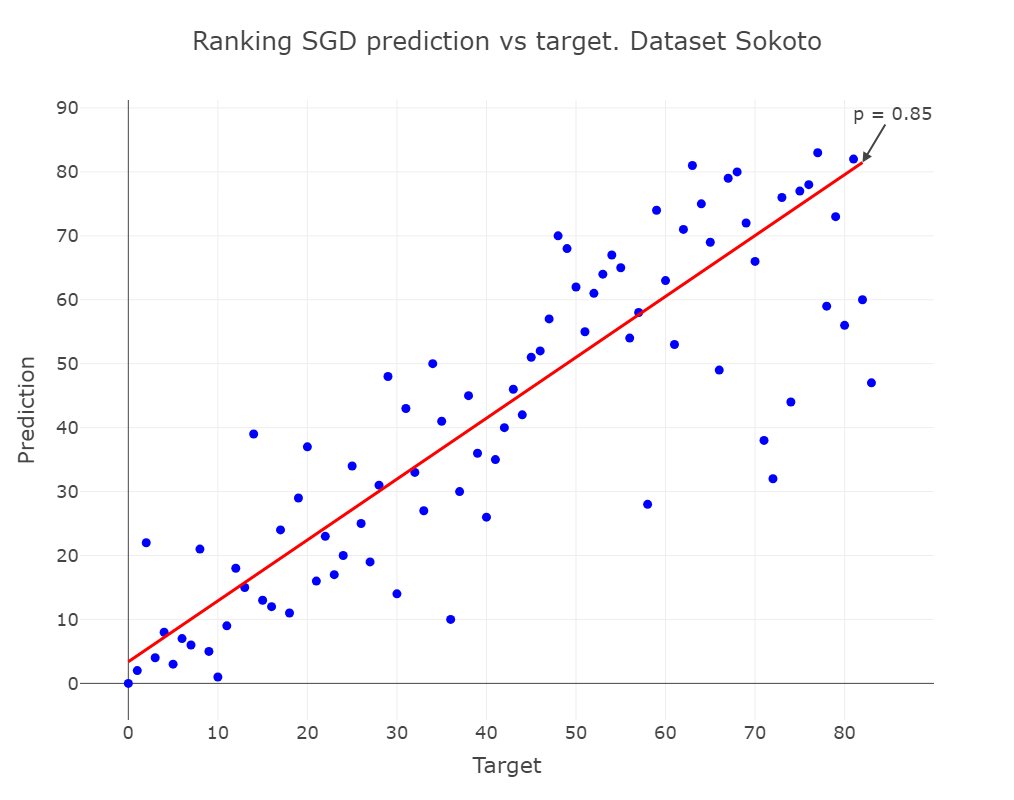

In [48]:
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
from sklearn import datasets, linear_model
rg_name="SGD"


X,y=sorted_ranks[rg_name]['target'].values.reshape(-1, 1), sorted_ranks[rg_name]['predict'].values.reshape(-1, 1)
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
fit_line_x = np.arange(X.min(), X.max())[:, np.newaxis]
fit_line_y = ransac.predict(fit_line_x)

# Calculate the correlation coefficient
#corr_coef = sorted_ranks[rg_name]['target'].corr(sorted_ranks[rg_name]['predict'])
corr_coef=spearmanr(X,y)[0]
# Fit a linear regression model
#slope, intercept, r_value, p_value, std_err = stats.linregress(sorted_ranks[rg_name]['target'], sorted_ranks[rg_name]['predict'])

# Generate points for the fit line
#fit_line_x = np.linspace(sorted_ranks[rg_name]['target'].min(), sorted_ranks[rg_name]['target'].max(), 100)
#fit_line_y = slope * fit_line_x + intercept

# Create scatter plot of the data points
scatter = go.Scatter(
    x=sorted_ranks[rg_name]['target'], 
    y=sorted_ranks[rg_name]['predict'], 
    mode='markers', 
    name='Data Points',
    marker=dict(color='blue')
)

# Create fit line plot
fit_line = go.Scatter(
    x=fit_line_x.flatten(), 
    y=fit_line_y.flatten(), 
    mode='lines', 
    name='Fit Line',
    line=dict(color='red')
)

# Create the layout with the fit line equation and correlation coefficient as annotations
layout = go.Layout(
    title=f"Ranking {rg_name} prediction vs target. Dataset {test_dataset}",
    xaxis=dict(title="Target"),
    yaxis=dict(title="Prediction"),
    annotations=[
        dict(
            x=fit_line_x.max(), 
            y=fit_line_y.max(), 
            xref="x", 
            yref="y", 
            text=f"p = {corr_coef:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=30,
            ay=-50
        )
    ],
    width=1200,  # Adjust the width of the figure
    height=800,
    template="presentation",
    showlegend=False 
)

# Combine the scatter plot and fit line
fig = go.Figure(data=[scatter, fit_line], layout=layout)

fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}.svg",format="SVG")
fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}.png",format="PNG")
# Show the plot
fig.show()

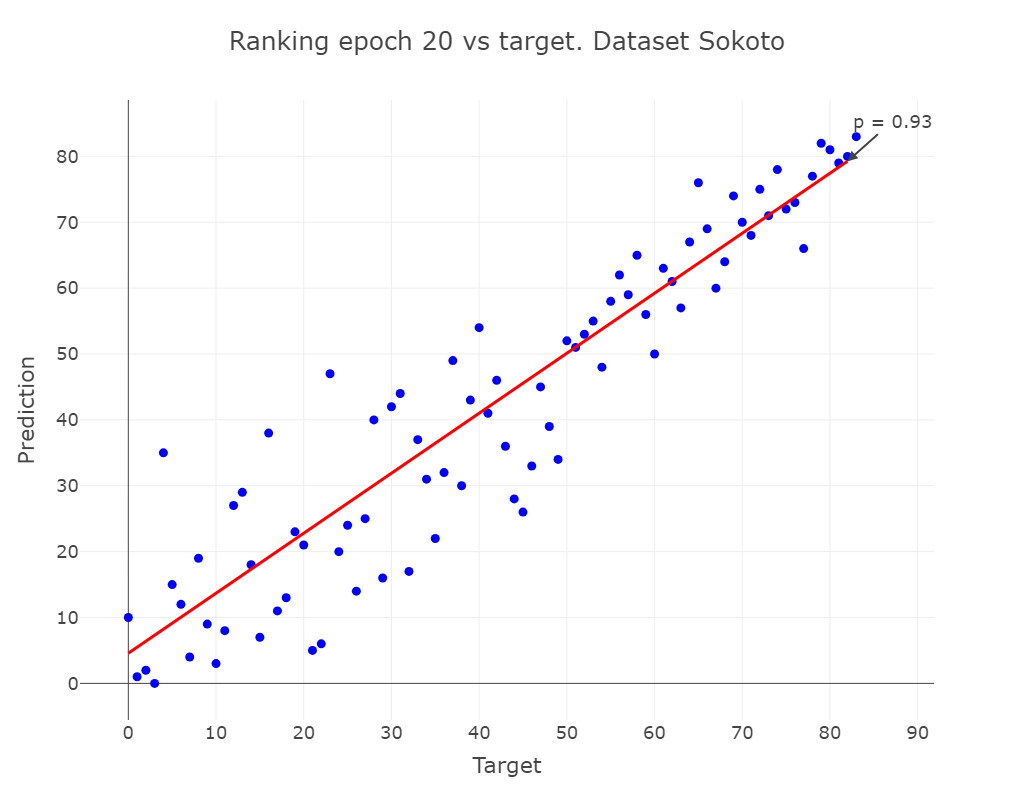

In [52]:
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
epoch=20

rg_name="SGD"


X,y=sorted_ranks_epochs[epoch]['target'].values.reshape(-1, 1), sorted_ranks_epochs[epoch]['predict'].values.reshape(-1, 1)
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
fit_line_x = np.arange(X.min(), X.max())[:, np.newaxis]
fit_line_y = ransac.predict(fit_line_x)

# Calculate the correlation coefficient
#corr_coef = sorted_ranks[rg_name]['target'].corr(sorted_ranks[rg_name]['predict'])
corr_coef=spearmanr(X,y)[0]


# Create scatter plot of the data points
scatter = go.Scatter(
    x=sorted_ranks_epochs[epoch]['target'], 
    y=sorted_ranks_epochs[epoch]['predict'], 
    mode='markers', 
    name='Data Points',
    marker=dict(color='blue')
)

# Create fit line plot
fit_line = go.Scatter(
    x=fit_line_x.flatten(), 
    y=fit_line_y.flatten(), 
    mode='lines', 
    name='Fit Line',
    line=dict(color='red')
)

# Create the layout with the fit line equation and correlation coefficient as annotations
layout = go.Layout(
    title=f"Ranking epoch {epoch} vs target. Dataset {test_dataset}",
    xaxis=dict(title="Target"),
    yaxis=dict(title="Prediction"),
    annotations=[
        dict(
            x=fit_line_x.max(), 
            y=fit_line_y.max(), 
            xref="x", 
            yref="y", 
            text=f"p = {corr_coef:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=45,
            ay=-40
        )
    ],
    width=1200,  # Adjust the width of the figure
    height=800,
    template="presentation",
    showlegend=False 
)

# Combine the scatter plot and fit line
fig = go.Figure(data=[scatter, fit_line], layout=layout)

fig.write_image(f"regressors/{test_dataset}/ranking_{epoch}.svg",format="SVG")
fig.write_image(f"regressors/{test_dataset}/ranking_{epoch}.png",format="PNG")
# Show the plot
fig.show()